In [294]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from fireworks.nbodylib.integrators import integrator_leapfrog, integrator_leapfrog_galaxy, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [295]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# Slicing the dataframe to reduce computation time
num_particles = int(1e2)
df = df_0.iloc[:num_particles]

#I create a class with the mass, pos, vel of each element of the Galaxy
masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
# reshape mass array to 1D array (required by pyfalcon)
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
#I can do the same for the other Galaxy. This second galaxy is the same as the first one, but translated by a certain value. In particular I have
pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

#So, I just apply this translation to find the second galaxy
positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

# Orbital integration of Galaxy 1

In [296]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time = []
    timestep = []
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []
    

    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, _, updated_acc, _, _ = result
        updated_galaxy.pos -= updated_galaxy.pos[0]  # move the galaxy to the center of mass
        updated_galaxy.vel -= updated_galaxy.vel[0]
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
        
        timestep.append(h)
        t = t + h
        time.append(t)


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)
    timestep  = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    return path, velocity, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, timestep

In [297]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)
G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere

central_mass = galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(Galaxy1.radius()**3 / (G * central_mass))                  # period of the galaxy for the average radius
T = np.mean(T)

print(f'Average period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_timestep = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

Average period of the galaxy (approximately): 98.32665772930324


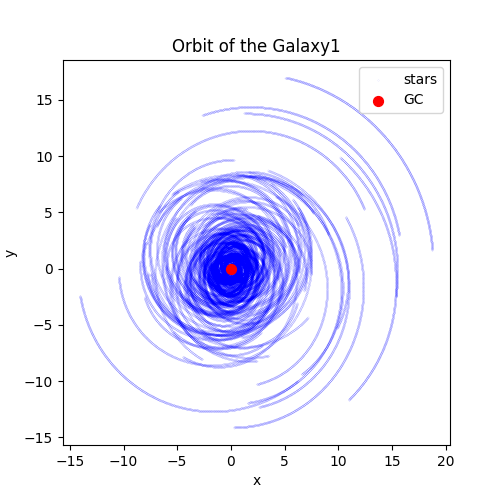

In [298]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.001, color='blue', label='stars')
plt.scatter(Galaxy1_orbit[0,0,0], Galaxy1_orbit[0,0,1], s=50, color='red', label='GC')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
#plt.show()

# Rotation Curve

In [299]:
def rotation_curve(x, y, z, vx, vy, vz):

    r_cyl   = np.sqrt(x**2 + y**2)
    phi     = np.arctan2(y,x)
    z       = z

    v_phi   = vy * np.cos(phi) - vx * np.sin(phi)

    return r_cyl, z, v_phi 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


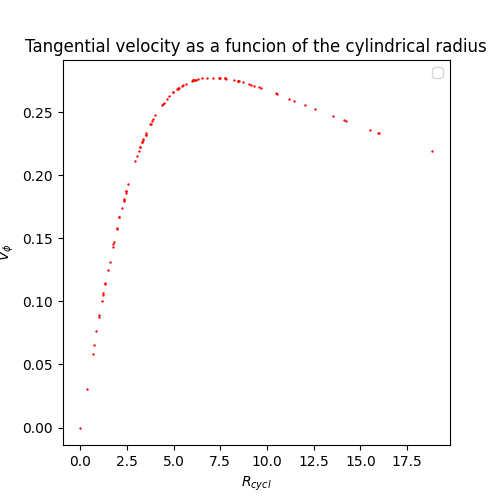

In [300]:
# plot
plt.figure(figsize=(5, 5))
plt.scatter(R_cyl, vel_phi, s=0.5, color='red')
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a funcion of the cylindrical radius')
plt.legend(loc='best')
plt.show()

In [301]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time = []
    timestep = []
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    R_cyl, _, vel_phi = rotation_curve( Galaxy1.pos[:,0], Galaxy1.pos[:,1], Galaxy1.pos[:,2], Galaxy1.vel[:,0], Galaxy1.vel[:,1], Galaxy1.vel[:,2] )

    R_cyl = [R_cyl]
    V_phi = [vel_phi]
    

    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, _, updated_acc, _, _ = result
        #updated_galaxy.pos -= updated_galaxy.pos[0]  # move the galaxy to the center of mass
        #updated_galaxy.vel -= updated_galaxy.vel[0]
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)

        R , z, V = rotation_curve( updated_galaxy.pos[:,0], updated_galaxy.pos[:,1], updated_galaxy.pos[:,2], 
                                           updated_galaxy.vel[:,0], updated_galaxy.vel[:,1], updated_galaxy.vel[:,2] )
        
        timestep.append(h)
        t = t + h
        time.append(t)
        R_cyl.append(R)
        V_phi.append(V)



    path        = np.array(path)
    velocity    = np.array(velocity)
    time        = np.array(time)
    timestep    = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    R_cyl       = np.array(R_cyl)
    V_phi       = np.array(V_phi)


    return path, velocity, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, timestep, R_cyl, V_phi

In [302]:
Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_timestep, Galaxy1_Rcyl, Galaxy1_Vphi = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

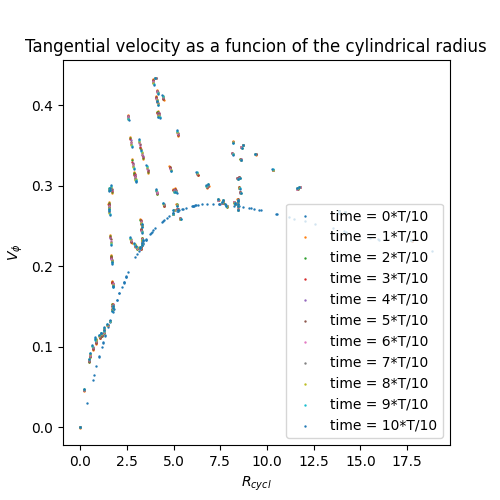

In [319]:
plt.figure(figsize=(5, 5))
snapshots = np.arange(0,T+1,T/10)
for i in range (len(snapshots)):
    plt.scatter(Galaxy1_Rcyl[i], Galaxy1_Vphi[i], s=0.5, label=f'time = {i}*T/10')
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a funcion of the cylindrical radius')
plt.legend(loc='best')
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


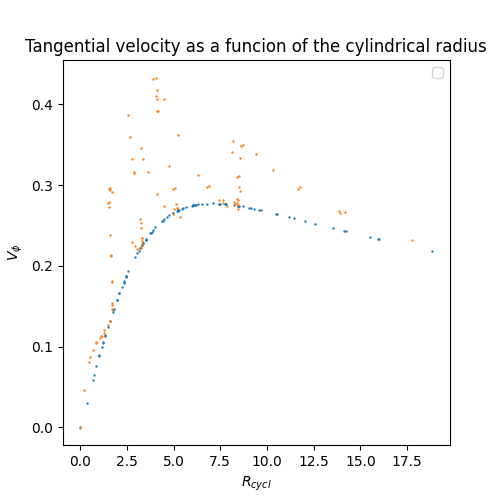

In [320]:
plt.figure(figsize=(5, 5))
plt.scatter(Galaxy1_Rcyl[0], Galaxy1_Vphi[0], s=0.5)
plt.scatter(Galaxy1_Rcyl[1], Galaxy1_Vphi[1], s=0.5)
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a funcion of the cylindrical radius')
plt.legend(loc='best')
plt.show()  

LOOOL GIÀ DOPO UN TIMESTEP MA CHE CAZZO SUCCEDEEEEEEEEEEEEE